Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
import datetime

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
TRAIN_DATASET_PATH = 'C:/Users/HOME/Desktop/train.csv'
TEST_DATASET_PATH = 'C:/Users/HOME/Desktop/test.csv'

In [3]:
class preproc: 
    
    def evaluate_preds(self,train_true_values, train_pred_values, test_true_values, test_pred_values):
        print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
        print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

        plt.figure(figsize=(18,10))

        plt.subplot(121)
        sns.scatterplot(x=train_pred_values, y=train_true_values)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')
        plt.title('Train sample prediction')

        plt.subplot(122)
        sns.scatterplot(x=test_pred_values, y=test_true_values)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')
        plt.title('Test sample prediction')

        plt.show()
    
    def reduce_mem_usage(self, df):
        """ iterate through all the columns of a dataframe and modify the data type
            to reduce memory usage.        
        """
        start_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

        for col in df.columns:
            col_type = df[col].dtype

            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        return df
    
    def df_add_dummy (self, train_df): #Замена категориальных переменных на дамми переменные
            train_df['DistrictId'] = train_df['DistrictId'].astype(str)
            train_df = train_df.drop('Id', axis =1 )
            train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'],dtype='int64')], axis=1)
            train_df.rename(columns = {'A' : 'Ecology_2_dummy_A', 'B' : 'Ecology_2_dummy_B'}, inplace = True)
            train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_3'],dtype='int64')], axis=1)
            train_df.rename(columns = {'A' : 'Ecology_3_dummy_A', 'B' : 'Ecology_3_dummy_B'}, inplace = True)
            train_df = pd.concat([train_df, pd.get_dummies(train_df['Shops_2'],dtype='int64')], axis=1)
            train_df.rename(columns = {'A' : 'Shops_2_dummy_A', 'B' : 'Shops_2_dummy_B'}, inplace = True)
            return train_df
            
    def df_resolve_Rooms (self, train_df,median_Rooms): # устранение выбросов по комната
            train_df.loc[train_df['Rooms'] > 8, 'Rooms'] = median_Rooms
            train_df.loc[train_df['Rooms'] == 0 , 'Rooms'] = median_Rooms
            return train_df
            
    def df_resolve_square (self, train_df,median_LifeSquare,mean_square_life,mean_square_kitchen): # устранение выбросов по площадям

            train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = median_LifeSquare
            train_df.describe()

            train_df.loc[(train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.975)) |
            (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.025)), 'LifeSquare' ] = mean_square_life*train_df['Square']

            train_df.loc[(train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975)) |
            (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.025)), 'KitchenSquare' ] = mean_square_kitchen*train_df['Square']

            train_df.loc[train_df['KitchenSquare'] > train_df['LifeSquare'],'KitchenSquare']  = train_df['Square'] - train_df['LifeSquare']
            train_df.loc[train_df['LifeSquare']>train_df['Square'], 'LifeSquare'] = mean_square_life*train_df['Square']
            train_df.loc[train_df['LifeSquare']+ train_df['KitchenSquare']>train_df['Square'], 'LifeSquare'] = mean_square_life*train_df['Square']
            train_df.loc[train_df['LifeSquare']+ train_df['KitchenSquare']>train_df['Square'], 'KitchenSquare'] = train_df['Square'] - train_df['LifeSquare']

            return train_df
        
    def resolve_floor(self, train_df,mean_floor_HouseFloor): # устранение выбросов по этажам
            
            train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = round(train_df['HouseFloor'].quantile(0.25))
            train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = mean_floor_HouseFloor*train_df['HouseFloor']
            return train_df
        
    def resolve_helthCare (self, train_df,helth_median): # устранение выбросов по здоровью
        train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = helth_median
        return train_df
    
    def resolve_year  (self, train_df, year_median): # устранение выбросов по году
        now = datetime.datetime.now()
        train_df.loc[train_df['HouseYear'] > now.year, 'HouseYear'] = year_median
        return train_df


Загрузка данных

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

Обзор обучающего датасета

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [6]:
median_Rooms = train_df['Rooms'].median()
mode_Rooms = train_df['Rooms'].mode()
mean_Rooms = train_df['Rooms'].mean()

In [7]:
median_LifeSquare = train_df['LifeSquare'].median()
mode_LifeSquare = train_df['LifeSquare'].mode()
mean_LifeSquare= train_df['LifeSquare'].mean()

In [8]:
df = train_df[
        (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.975)) &
        (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.025)) &
        (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.975)) &
        (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.025))]

mean_square_life = sum(df['LifeSquare']/df['Square'])/len(df['Square'])
mean_square_kitchen= sum(df['KitchenSquare']/df['Square'])/len(df['Square'])


In [9]:
df = train_df.loc[train_df['Floor'] < train_df['HouseFloor']]

mean_floor_HouseFloor = sum(df['Floor']/df['HouseFloor'])/len(df['HouseFloor'])

In [10]:
median_helth = train_df['Healthcare_1'].median()

In [11]:
median_year = train_df['HouseYear'].median()

In [12]:
tom = preproc()
train_df = tom.df_add_dummy(train_df)
train_df = tom.df_resolve_Rooms(train_df,median_Rooms)
train_df = tom.df_resolve_square(train_df,median_LifeSquare,mean_square_life,mean_square_kitchen)
train_df = tom.resolve_floor(train_df,mean_floor_HouseFloor)
train_df = tom.resolve_helthCare(train_df,median_helth)
train_df = tom.resolve_year(train_df, median_year)
train_df = tom.reduce_mem_usage(train_df)

Memory usage of dataframe is 1.91 MB
Memory usage after optimization is: 0.54 MB
Decreased by 71.5%


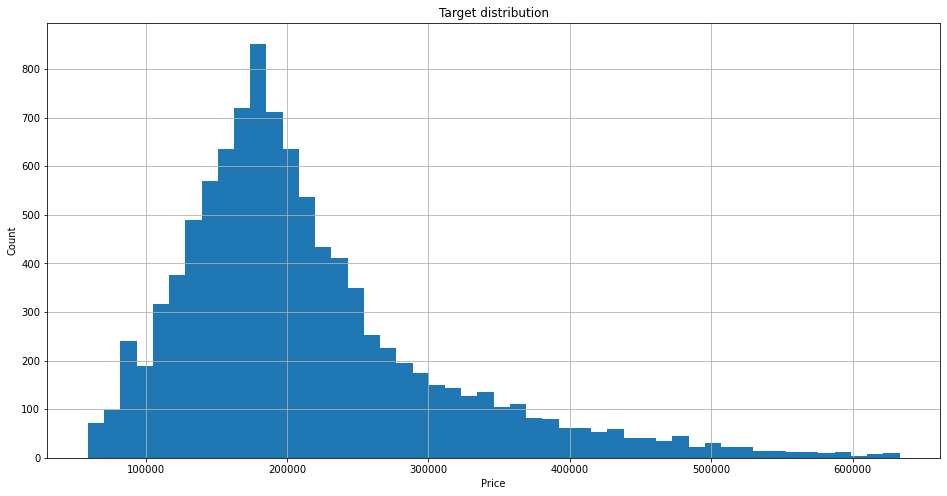

In [13]:
plt.figure(figsize=(16, 8))

train_df['Price'].hist(bins = 50)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Анализ данных

In [14]:
train_df['HouseFloor'].sort_values().unique(),train_df['Floor'].sort_values().unique()

(array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
         23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  36.,
         37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
       dtype=float32),
 array([ 0.53907895,  1.        ,  1.0781579 ,  1.6172369 ,  2.        ,
         2.1563158 ,  2.6953948 ,  3.        ,  3.2344737 ,  3.7735527 ,
         4.        ,  4.3126316 ,  4.851711  ,  5.        ,  5.3907895 ,
         5.9298687 ,  6.        ,  6.4689474 ,  7.        ,  7.0080266 ,
         7.5471053 ,  8.        ,  8.0861845 ,  8.625263  ,  9.        ,
         9.164342  ,  9.703422  , 10.        , 10.2425    , 10.781579  ,
        11.        , 11.320658  , 11.859737  , 12.        , 12.398816  ,
        12.937895  , 13.        , 13.476974  , 14.        , 15.        ,
        16.        , 17.        , 18.        , 19.        , 20.        ,
        21.        , 22.     

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   DistrictId         10000 non-null  category
 1   Rooms              10000 non-null  float32 
 2   Square             10000 non-null  float32 
 3   LifeSquare         10000 non-null  float32 
 4   KitchenSquare      10000 non-null  float32 
 5   Floor              10000 non-null  float32 
 6   HouseFloor         10000 non-null  float32 
 7   HouseYear          10000 non-null  int16   
 8   Ecology_1          10000 non-null  float32 
 9   Ecology_2          10000 non-null  category
 10  Ecology_3          10000 non-null  category
 11  Social_1           10000 non-null  int8    
 12  Social_2           10000 non-null  int16   
 13  Social_3           10000 non-null  int16   
 14  Healthcare_1       10000 non-null  float32 
 15  Helthcare_2        10000 non-null  int8    
 16  Shops

In [16]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_dummy_A,Ecology_2_dummy_B,Ecology_3_dummy_A,Ecology_3_dummy_B,Shops_2_dummy_A,Shops_2_dummy_B
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.315720,34.158615,5.65207,7.321781,12.851500,1984.863800,0.118858,24.687000,5352.157400,...,1026.358887,1.319500,4.231300,214138.937500,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,0.812107,21.058716,12.844291,3.84206,4.955578,6.475202,18.409979,0.119025,17.532614,4006.799803,...,746.644226,1.493601,4.806341,92872.273438,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,1.000000,1.136859,0.742258,0.00000,0.539079,1.000000,1910.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,0.000000,59174.777344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774879,25.658140,1.00000,3.773553,9.000000,1974.000000,0.017647,6.000000,1564.000000,...,830.000000,0.000000,1.000000,153872.628906,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,2.000000,52.513309,32.781261,6.00000,6.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,...,900.000000,1.000000,3.000000,192269.648438,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,2.000000,65.900627,39.229887,9.00000,10.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,...,990.000000,2.000000,6.000000,249135.460938,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,6.000000,641.065186,418.553101,38.41169,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,...,4849.000000,6.000000,23.000000,633233.437500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
train_df['HouseYear'].sort_values().unique()

array([1910, 1912, 1914, 1916, 1917, 1918, 1919, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1947, 1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int16)

Отбор признаков
Подбор моделей, получение бейзлана

Train R2:	0.96
Test R2:	0.716


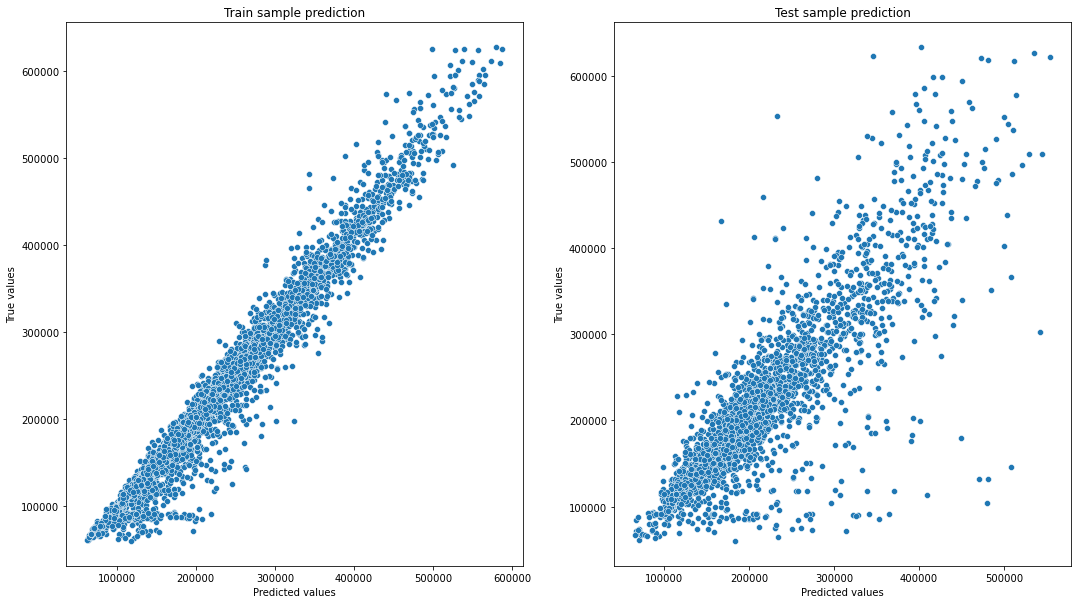

In [18]:
feat = ['Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Healthcare_1','Helthcare_2','Shops_1']
x = train_df[feat]
y = train_df['Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 73)

forest = RandomForestRegressor()
forest.fit(x_train, y_train)

tom = preproc()

train_pred = forest.predict(x_train)
test_pred = forest.predict(x_test)
tom.evaluate_preds(y_train, train_pred, y_test, test_pred)

Итоговое предсказание

In [21]:
forest = RandomForestRegressor()
forest.fit(x, y)

tom = preproc()
test_df = tom.df_resolve_Rooms(train_df,median_Rooms)
test_df = tom.df_resolve_square(train_df,median_LifeSquare,mean_square_life,mean_square_kitchen)
test_df = tom.resolve_floor(train_df,mean_floor_HouseFloor)
test_df = tom.resolve_helthCare(train_df,median_helth)
test_df = tom.resolve_year(train_df, median_year)

pred = pd.DataFrame(forest.predict(test_df[feat]), columns=['pred'])
pred

,pred
0,314358.817188
1,177231.746719
2,290488.550469
3,160410.956016
4,328088.165625
...,...
9995,161899.230000
9996,199916.477187
9997,152785.244688
9998,162826.768984


In [22]:
pred.to_csv('Lomakin_predict.csv')